# Urban and rural surrounding areas selection

***
> This work is licensed under a [Creative Commons Attribution 4.0 International License](http://creativecommons.org/licenses/by/4.0)
>
> ![Creative Commons License >](https://i.creativecommons.org/l/by/4.0/88x31.png)

## Load libraries

Here we load the required libraries to execute the notebook. Note that specific code from dedicated scripts (`utils.py`, `urban_areas.py`, ...) is also loaded here.

In [1]:
import os
import numpy as np
import xarray as xr
import cf_xarray as cfxr
from pathlib import Path
import glob
import re
import geopandas as gpd
import pandas as pd

import xesmf as xe



from urbanmask.urban_areas import (
    Urban_vicinity,
)

from urbanmask.UHI_plot_functions import (
    plot_climatology,
    plot_annual_cicle,
    plot_daily_cicle
)

from urbanmask.utils import (
    kelvin2degC,
    traverseDir,
    fix_360_longitudes,
)

## Input parameters

These parameters define the behaviour of the notebook, by selecting the `city`, `variable`, and some other items which are mostly self-explanatory. _(Explain here those with are not)_

In [2]:
city = 'BuenosAires'
lon_city = -58.3816
lat_city = -34.6037


domain = 'CSAM-4i'
version = 'v1'
model = 'UCAN'
scenario = "evaluation"

urban_th = 60
urban_sur_th = 1
orog_diff = 100
sftlf_th = 70
scale = 2
min_city_size = 3
lon_lim = 1
lat_lim = 2

urban_var = 'sftuf'

variable='sfcWind'

In [3]:
city = 'Cordoba'
lon_city = -64.1888
lat_city = -31.4201


domain = 'CSAM-4i'
version = 'v1'
model = 'UCAN'
scenario = "evaluation"

urban_th = 60
urban_sur_th = 1
orog_diff = 100
sftlf_th = 70
scale = 2
min_city_size = 3
lon_lim = 1
lat_lim = 2

urban_var = 'sftuf'

variable='sfcWind'

Create a directory to save the results for this particular city and model

In [4]:
base_output_dir = 'results'
if model in ['NCAR', 'UCAN']:
    output_dir = f"{base_output_dir}/{city}-{domain}_{model}-WRF433-{version}"
elif model in ['USP']:
    output_dir = f"{base_output_dir}/{city}-{domain}_{model}-RegCM471-{version}"
elif  model in ['ICTP']:
    output_dir = f"{base_output_dir}/{city}-{domain}_{model}-{version}-v0"
os.makedirs(output_dir, exist_ok = True)

In [5]:
os.makedirs(f'results/{city}-CSAM-4i_OBS', exist_ok = True)

Infer doman resolution in degrees and create filename

In [6]:
domain_resolution = int( re.search(r'(\d+)', domain.split('-')[1]).group(1))
base_filename = f'{city}-{domain}_{model}-{version}_{scenario}_r1i1p1f1'
if model in ['NCAR', 'UCAN']:
    base_filename = f'{city}-{domain}_{model}-WRF433-{version}_{scenario}_r1i1p1f1'
elif model in ['USP', 'ICTP']:
    base_filename = f'{city}-{domain}_{model}-RegCM471-{version}_{scenario}_r1i1p1f1'

## Define urban areas and vicinity

Add parameters to the function

In [7]:
URBAN = Urban_vicinity(
    urban_th, 
    urban_sur_th, 
    orog_diff, 
    sftlf_th,
    scale,
    min_city_size,
    lon_city,
    lat_city,
    lon_lim,
    lat_lim,
    model,
    domain,
    urban_var)

### Load static variables
Load static variables, such as urban fraction (sfturf), terrain elevation (orography) or land-sea fraction (sftlf).

In [8]:
root = f'/lustre/gmeteo/WORK/ASNA/projects/fpssam/03_FPS-SESA-ext-CPM/data/CORDEX-FPS-SESA/output/{domain}/{model}/*/evaluation/*/{model}-*/{version}/'
USP_version = "v"+version[-1]
if model == 'ICTP':
    root = f'/lustre/gmeteo/WORK/ASNA/projects/fpssam/03_FPS-SESA-ext-CPM/data/CORDEX-FPS-SESA/output/{domain}/USP/*/evaluation/*/USP-*/{USP_version}/'
root_urban = f'/lustre/gmeteo/WORK/ASNA/projects/fpssam/03_FPS-SESA-ext-CPM/data/CORDEX-FPS-SESA/output/CSAM-4/USP/ECMWF-ERA5/evaluation/r1i1p1f1/USP-RegCM471/{USP_version}/'

In [9]:
file_pattern = f'{root}fx/orog/orog_{domain}_*.nc'
file_list = glob.glob(file_pattern)
ds_orog = xr.open_dataset(file_list[0], engine='netcdf4')

file_pattern = f'{root}fx/sftlf/sftlf_{domain}_*.nc'
file_list = glob.glob(file_pattern)
ds_sftlf = xr.open_dataset(file_list[0], engine='netcdf4')

if model in ['USP','ICTP']:
    file_pattern = f'{root_urban}fx/sftimf/*'
    file_list = glob.glob(file_pattern)
    ds_sftuf_native = xr.open_dataset(file_list[0], engine='netcdf4')
    ds_sftuf_native['sftuf'] = (ds_sftuf_native['sftimf']) / 1e40

else: 
    file_pattern = f'{root}fx/landuse/landuse_{domain}_*.nc'
    file_list = glob.glob(file_pattern)
    ds_sftuf = xr.open_dataset(file_list[0], engine='netcdf4')
    ds_sftuf['sftuf'] = (ds_sftuf['landuse'] == 13)*100

Crop area around de city

In [10]:
ds_orog = URBAN.crop_area_city(ds_orog, domain_resolution)
ds_sftlf = URBAN.crop_area_city(ds_sftlf, domain_resolution)
if model in ['USP','ICTP']:
    
    # Crear un remapeador con nearest neighbor
    regridder = xe.Regridder(ds_sftuf_native, ds_orog, method='nearest_s2d')
    
    # Aplicar la interpolación
    ds_sftuf = regridder(ds_sftuf_native)

else:
    ds_sftuf = URBAN.crop_area_city(ds_sftuf, domain_resolution)

In [11]:
def crop_area(ds, lat_city, lon_city, range_size, 
              y, x, lat, lon):
    
    iy = ds[y]; jx = ds[x]
    xlat = ds[lat]; xlon = ds[lon]

    # Step 1: Find the closest indices
    # Flatten the latitude and longitude arrays
    flat_lat = xlat.values.flatten()
    flat_lon = xlon.values.flatten()
    
    # Compute the distances
    distances = np.sqrt((flat_lat - lat_city)**2 + (flat_lon - lon_city)**2)
    
    # Find the index of the minimum distance
    min_index = np.argmin(distances)
    
    # Get the 2D index from the 1D index
    iy_index, jx_index = np.unravel_index(min_index, xlat.shape)
    
    # Step 2: Define a range around this point
    
    iy_start = max(iy_index - range_size, 0)
    iy_end = min(iy_index + range_size, len(iy) - 1)
    
    jx_start = max(jx_index - range_size, 0)
    jx_end = min(jx_index + range_size, len(jx) - 1)
    
    # Step 3: Select the area
    subset = ds.isel({y:slice(iy_start, iy_end), x:slice(jx_start, jx_end)})

    return subset

Define masks using the parameters above

In [12]:
sftuf_mask, sftuf_sur_mask, orog_mask, sftlf_mask = URBAN.define_masks(
    ds_sftuf, 
    ds_orog, 
    ds_sftlf
)

### Define rural vicinity areas

We use an iterative algorithm to select the urban vicinity excluding masked areas

In [13]:
urmask = URBAN.select_urban_vicinity(
    sftuf_mask, 
    orog_mask,
    sftlf_mask,
    sftuf_sur_mask
)

We can plot the masks and the urban vs vicinity areas. The latter are are passed via the `urban_areas` parameter. They are hidden if set to `None`.

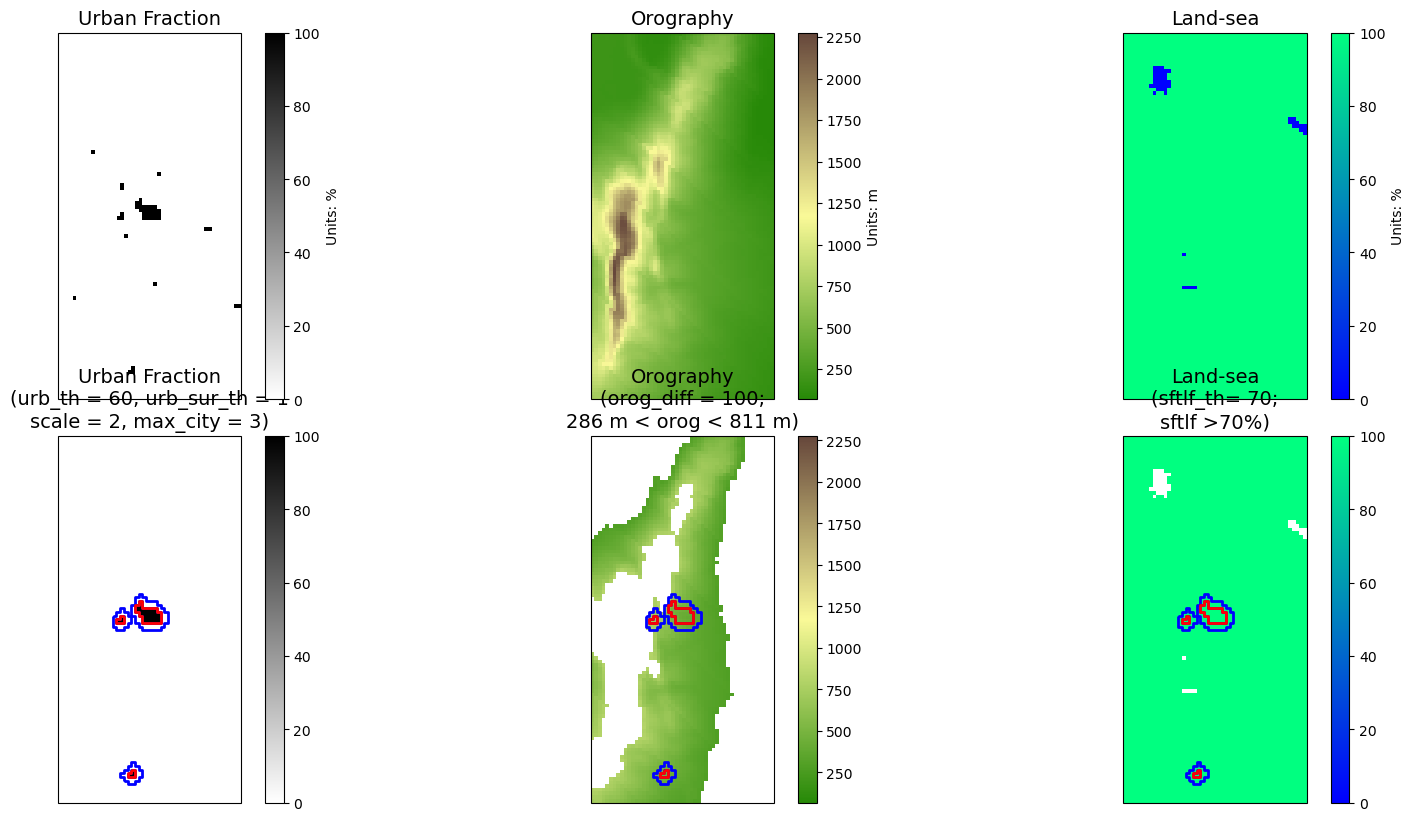

In [14]:
fig = URBAN.plot_static_variables(ds_sftuf, ds_orog, ds_sftlf,
                                 sftuf_mask, orog_mask, sftlf_mask,
                                 urban_areas = urmask)
fig.savefig(f"{output_dir}/urmask_{base_filename}_fx.pdf", bbox_inches='tight')

## Load climate variable

In [15]:
file_pattern = f'{root}day/{variable}/*'
files = np.sort(glob.glob(file_pattern))
ds_RCM = xr.open_mfdataset(files, concat_dim='time', combine='nested')
ds_RCM = kelvin2degC(ds_RCM, variable)
ds_RCM = fix_360_longitudes(ds_RCM)
ds_RCM = URBAN.crop_area_city(ds_RCM, domain_resolution).compute()

## Load observations

In [16]:
import pandas as pd
loc = {
    'BuenosAires': dict(
        urb=dict(lat=-34.583, lon=-58.500),
        rur=dict(lat=-34.817, lon=-58.533)  # Ezeiza
    ),
    'Cordoba': dict(
        urb=dict(lat=-31.400, lon=-64.167),
        rur=dict(lat=-31.3, lon=-64.127)  # Aero moved to non-urban gridcell
    ),
#    'Porto Alegre': dict(  # made up points
#        urb=dict(lat=-30.032, lon=-51.174),
#        rur=dict(lat=-30.152, lon=-51.061)
#    ),
}

# Crear lista para almacenar las filas
data = []

# Iterar sobre los datos para construir el DataFrame
for place, locations in loc.items():
    for urban_type, coords in locations.items():
        data.append({
            'city': place,
            'urban': 'Urban' if urban_type == 'urb' else 'Rural',
            'lat': coords['lat'],
            'lon': coords['lon']
        })

# Crear el DataFrame
df = pd.DataFrame(data)

In [17]:
import pandas as pd
import os
import glob

def load_city_data(city, base_dir="/lustre/gmeteo/WORK/ASNA/projects/fpssam/03_FPS-SESA-ext-CPM/data/urban_station_data/Datos"):
    """
    Loads and merges data files for a given city, and calculates daily minimum and maximum temperatures.
    Returns two DataFrames: one for urban stations and one for rural stations.
    
    Parameters:
        base_dir (str): The base directory where the files are located.
        city (str): The city name to match the files. The city will be converted to uppercase.
    
    Returns:
        pd.DataFrame, pd.DataFrame: Two DataFrames: one for urban stations and one for rural stations.
    """
    
    # Define the station names for each city
    st_name = {
        'BuenosAires': dict(urb='BSAS-OBS', rur='EZEIZA-AERO'),
        'Cordoba': dict(urb='CORDOBA-OBS', rur='CORDOBA-AERO'),
    }
    # Create search patterns for both urban and rural files
    search_patterns = [
        os.path.join(base_dir, f"2018-2021-{st_name[city]['urb']}*.dat"),
        os.path.join(base_dir, f"2018-2021-{st_name[city]['rur']}*.dat")
    ]
    
    # Initialize an empty list to store all the files
    files = []
    
    # Use glob to find all matching files for both urban and rural
    for pattern in search_patterns:
        files.extend(glob.glob(pattern))
    
    if not files:
        print(f"No files found for {city} in {base_dir}.")

    # List to store DataFrames
    dfs = []
    
    # Load each file using pandas
    for file in files:
        print(f"Loading {file}")
        
        # Extract station name (last word before .dat in the filename)
        station_name = file.split('/')[-1].split('.')[0].split('-')[-1]
        
        # Assuming the file is in a CSV-like format
        try:
            df = pd.read_csv(file, delimiter="\s+", header=None, on_bad_lines='skip')
            df[4] = pd.to_numeric(df[4], errors='coerce')
            df[3] = df[3].astype(int)  # Asegurar que la hora es un entero
            df['DATE'] = pd.to_datetime(df[[0, 1, 2, 3]].astype(str).agg('-'.join, axis=1), format='%Y-%m-%d-%H')
            
            # Drop the original year, month, day, and hour columns
            df = df.drop([0, 1, 2, 3], axis=1)
            
            # Remove rows where column 5 has NaN values
            df = df.dropna(subset=[4])
            
            # Drop columns with all NaN values
            df = df.dropna(axis=1, how='all')

            # Rename columns to match the new names
            df.columns = ['tas','hurs', 'sfcWind', 'DATE']
            
            # Add station name as a new column
            df['Station Name'] = station_name
            
            dfs.append(df)
        except pd.errors.ParserError as e:
            print(f"Error parsing file {file}: {e}")
            continue  # Skip this file if there's a parsing error
    
    # Concatenate all DataFrames into a single DataFrame
    merged_data = pd.concat(dfs, ignore_index=True)
    
    # Ensure 'DATE' is a datetime type
    merged_data['DATE'] = pd.to_datetime(merged_data['DATE'])
    
    # Add 'day' column to group by day
    merged_data['day'] = merged_data['DATE'].dt.date
    
    # Calculate daily tasmin and tasmax
    daily_min_max = merged_data.groupby(['day', 'Station Name'])['tas'].agg(tasmin='min', tasmax='max').reset_index()
    
    # Merge the daily min/max back into the main DataFrame
    merged_data = merged_data.merge(daily_min_max, on=['day', 'Station Name'], how='left')

    # Drop the 'day' column as it's no longer needed
    merged_data = merged_data.drop(columns=['day'])
    
    # Filter for urban and rural stations based on the station names
    urb_data = merged_data[merged_data['Station Name'] == 'OBS']
    rur_data = merged_data[merged_data['Station Name'] == 'AERO']
    
    return urb_data, rur_data, merged_data


<>:51: SyntaxWarning: invalid escape sequence '\s'
<>:51: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_55521/4025317591.py:51: SyntaxWarning: invalid escape sequence '\s'
  df = pd.read_csv(file, delimiter="\s+", header=None, on_bad_lines='skip')


In [18]:
df_urb,df_rur,time_series_obs = load_city_data(city)

Loading /lustre/gmeteo/WORK/ASNA/projects/fpssam/03_FPS-SESA-ext-CPM/data/urban_station_data/Datos/2018-2021-CORDOBA-OBS.dat
Loading /lustre/gmeteo/WORK/ASNA/projects/fpssam/03_FPS-SESA-ext-CPM/data/urban_station_data/Datos/2018-2021-CORDOBA-AERO.dat


## Heatwaves

In [19]:
import pandas as pd
import os

df_rur['DATE_only'] = pd.to_datetime(df_rur['DATE'], format='%Y-%m-%d', errors='coerce')
df_urb['DATE_only'] = pd.to_datetime(df_urb['DATE'], format='%Y-%m-%d', errors='coerce')
# Assuming df_urb is your DataFrame
df_rur['DATE_only'] = pd.to_datetime(df_rur['DATE_only']).dt.date  # Keep only date (year, month, day)

# Agrupar por fecha y obtener el máximo tasmax de cada día
df_daily_max = df_urb.groupby('DATE')['tasmax'].max().reset_index()

# Calcular el percentil 95 de tasmax
percentile_95 = df_daily_max['tasmax'].quantile(0.95)

# Filtrar fechas donde tasmax supera el percentil 95
df_exceedance = df_daily_max[df_daily_max['tasmax'] > percentile_95].copy()

# Eliminar posibles NaN por si acaso
df_exceedance = df_exceedance.dropna()

# Crear el DataFrame final
df_heatwaves = pd.DataFrame({
    'city': city,
    'model': 'OBS',
    'version': '',
    'exceedance_times': df_exceedance['DATE']
})

# Definir el archivo de salida
output_file = f'results/heatwave_urban.csv'

# Comprobar si el archivo ya existe
file_exists = os.path.isfile(output_file)

# Escribir en CSV (añadiendo al archivo si ya existe)
df_heatwaves.to_csv(output_file, mode='a', index=False, header=not file_exists)

print(df_heatwaves)

          city model version    exceedance_times
48     Cordoba   OBS         2018-01-03 00:00:00
49     Cordoba   OBS         2018-01-03 01:00:00
50     Cordoba   OBS         2018-01-03 02:00:00
51     Cordoba   OBS         2018-01-03 03:00:00
52     Cordoba   OBS         2018-01-03 04:00:00
...        ...   ...     ...                 ...
35059  Cordoba   OBS         2021-12-31 19:00:00
35060  Cordoba   OBS         2021-12-31 20:00:00
35061  Cordoba   OBS         2021-12-31 21:00:00
35062  Cordoba   OBS         2021-12-31 22:00:00
35063  Cordoba   OBS         2021-12-31 23:00:00

[1680 rows x 4 columns]


/tmp/ipykernel_55521/2433112256.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rur['DATE_only'] = pd.to_datetime(df_rur['DATE'], format='%Y-%m-%d', errors='coerce')
/tmp/ipykernel_55521/2433112256.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_urb['DATE_only'] = pd.to_datetime(df_urb['DATE'], format='%Y-%m-%d', errors='coerce')
/tmp/ipykernel_55521/2433112256.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_index

In [20]:
df_rur['DATE_only'] = pd.to_datetime(df_rur['DATE'], format='%Y-%m-%d', errors='coerce')
df_urb['DATE_only'] = pd.to_datetime(df_urb['DATE'], format='%Y-%m-%d', errors='coerce')
# Assuming df_urb is your DataFrame
df_rur['DATE_only'] = pd.to_datetime(df_rur['DATE_only']).dt.date  # Keep only date (year, month, day)

# Agrupar por fecha y obtener el máximo tasmax de cada día
df_daily_max = df_rur.groupby('DATE_only')['tasmax'].max().reset_index()


# Filtrar fechas donde tasmax supera el percentil 95
df_exceedance = df_daily_max[df_daily_max['tasmax'] > percentile_95].copy()

# Eliminar posibles NaN por si acaso
df_exceedance = df_exceedance.dropna()

# Crear el DataFrame final
df_heatwaves = pd.DataFrame({
    'city': city,
    'model': 'OBS',
    'version': '',
    'exceedance_times': df_exceedance['DATE_only']
})

# Definir el archivo de salida
output_file = f'results/heatwave_rural.csv'

# Comprobar si el archivo ya existe
file_exists = os.path.isfile(output_file)

# Escribir en CSV (añadiendo al archivo si ya existe)
df_heatwaves.to_csv(output_file, mode='a', index=False, header=not file_exists)

print(df_exceedance['DATE_only'])

3       2018-01-04
34      2018-02-04
35      2018-02-05
36      2018-02-06
37      2018-02-07
68      2018-03-10
264     2018-09-22
280     2018-10-08
288     2018-10-16
313     2018-11-10
344     2018-12-11
359     2018-12-26
362     2018-12-29
366     2019-01-02
417     2019-02-22
637     2019-09-30
647     2019-10-10
709     2019-12-11
722     2019-12-24
725     2019-12-27
800     2020-03-11
806     2020-03-17
807     2020-03-18
849     2020-04-29
889     2020-06-08
931     2020-07-20
1003    2020-09-30
1007    2020-10-04
1020    2020-10-17
1021    2020-10-18
1038    2020-11-04
1052    2020-11-18
1057    2020-11-23
1058    2020-11-24
1074    2020-12-10
1325    2021-08-18
1393    2021-10-25
1394    2021-10-26
1456    2021-12-27
1458    2021-12-29
1459    2021-12-30
1460    2021-12-31
Name: DATE_only, dtype: object


/tmp/ipykernel_55521/1289390741.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rur['DATE_only'] = pd.to_datetime(df_rur['DATE'], format='%Y-%m-%d', errors='coerce')
/tmp/ipykernel_55521/1289390741.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_urb['DATE_only'] = pd.to_datetime(df_urb['DATE'], format='%Y-%m-%d', errors='coerce')
/tmp/ipykernel_55521/1289390741.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_index

0       2018-01-01 00:00:00
1       2018-01-01 01:00:00
2       2018-01-01 02:00:00
3       2018-01-01 03:00:00
4       2018-01-01 04:00:00
                ...        
35059   2021-12-31 19:00:00
35060   2021-12-31 20:00:00
35061   2021-12-31 21:00:00
35062   2021-12-31 22:00:00
35063   2021-12-31 23:00:00
Name: DATE, Length: 35064, dtype: datetime64[ns]
hour
0     28.0
1     25.0
2     23.2
3     23.1
4     21.6
5     20.2
6     20.8
7     21.6
8     23.2
9     21.8
10    22.7
11    25.9
12    30.2
13    31.9
14    33.2
15    33.5
16    35.0
17    36.4
18    37.1
19    36.2
20    36.3
21    37.0
22    36.8
23    33.8
Name: tas, dtype: float64         tas  hurs  sfcWind                DATE Station Name  tasmin  tasmax  \
52080  28.0  0.43      4.1 2019-12-11 00:00:00         AERO    20.2    37.1   
52081  25.0  0.53      2.1 2019-12-11 01:00:00         AERO    20.2    37.1   
52082  23.2  0.58      1.5 2019-12-11 02:00:00         AERO    20.2    37.1   
52083  23.1  0.59      2.1 2019-

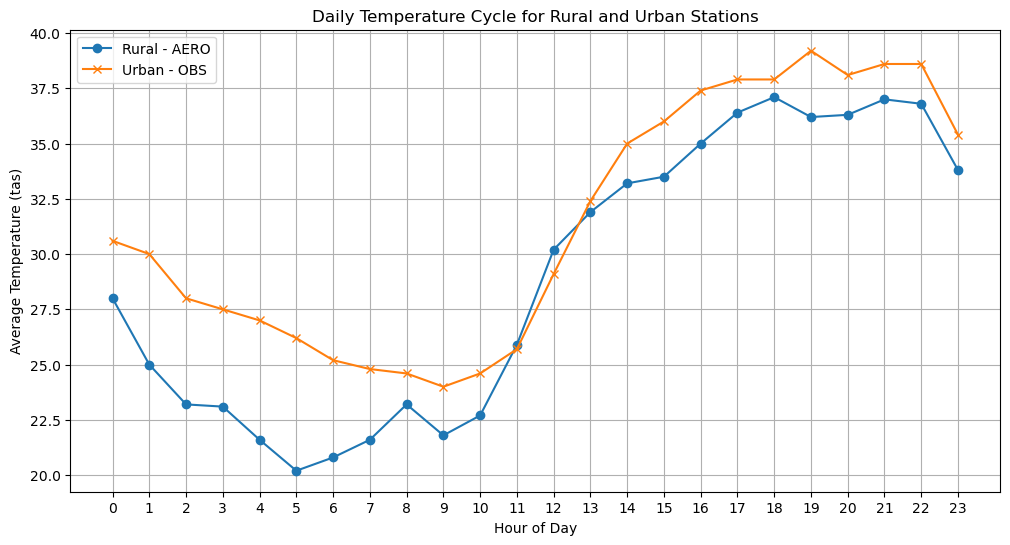

In [21]:
import pandas as pd
import matplotlib.pyplot as plt

# Convert the 'DATE' column to datetime, ensuring it's a copy to avoid SettingWithCopyWarning
df_exceedance = df_exceedance.copy()
df_rur = df_rur.copy()
df_urb = df_urb.copy()
# Convertir las columnas 'DATE' a datetime, manejando posibles errores
df_exceedance.loc[:, 'DATE'] = pd.to_datetime(df_exceedance['DATE_only'], errors='coerce')
df_rur.loc[:, 'DATE_only'] = pd.to_datetime(df_rur['DATE'], errors='coerce')
df_urb.loc[:, 'DATE_only'] = pd.to_datetime(df_urb['DATE'], errors='coerce')

df_rur['DATE_only'] = pd.to_datetime(df_rur['DATE_only'], format='%Y-%m-%d', errors='coerce')
df_urb['DATE_only'] = pd.to_datetime(df_urb['DATE_only'], format='%Y-%m-%d', errors='coerce')

# Intentar convertir utilizando un formato explícito (si conoces el formato exacto)
df_rur['DATE'] = pd.to_datetime(df_rur['DATE'], format='%Y-%m-%d %H:%M:%S', errors='coerce')
df_urb['DATE'] = pd.to_datetime(df_urb['DATE'], format='%Y-%m-%d %H:%M:%S', errors='coerce')

# Filtrar filas según la ciudad seleccionada y la fecha correspondiente
if city == 'Cordoba':
    selected_date = pd.to_datetime("2019-12-11")
elif city == 'BuenosAires':
    selected_date = pd.to_datetime("2019-01-28")

else:
    raise ValueError("City not recognized")

df_rur['DATE_only'] = pd.to_datetime(df_rur['DATE_only']).dt.date
df_urb['DATE_only'] = pd.to_datetime(df_urb['DATE_only']).dt.date
df_rur_filtered = df_rur[df_rur['DATE_only'] == selected_date.date()]
df_urb_filtered = df_urb[df_urb['DATE_only'] == selected_date.date()]

print(df_urb['DATE'])

# Ensure there is data before modifying and plotting
if not df_rur_filtered.empty:
    df_rur_filtered = df_rur_filtered.copy()
    df_rur_filtered.loc[:, 'hour'] = df_rur_filtered['DATE'].dt.hour

if not df_urb_filtered.empty:
    df_urb_filtered = df_urb_filtered.copy()
    df_urb_filtered.loc[:, 'hour'] = df_urb_filtered['DATE'].dt.hour

# Create the plot
plt.figure(figsize=(12, 6))

# Plot for rural stations
if not df_rur_filtered.empty:
    station_names_rur = df_rur_filtered['Station Name'].unique()
    for station in station_names_rur:
        station_data_rur = df_rur_filtered[df_rur_filtered['Station Name'] == station]
        daily_cycle_rur = station_data_rur.groupby('hour')['tas'].mean()
        print(daily_cycle_rur,station_data_rur)
        plt.plot(daily_cycle_rur.index, daily_cycle_rur.values, label=f'Rural - {station}', marker='o')

# Plot for urban stations
if not df_urb_filtered.empty:
    station_names_urb = df_urb_filtered['Station Name'].unique()
    for station in station_names_urb:
        station_data_urb = df_urb_filtered[df_urb_filtered['Station Name'] == station]
        daily_cycle_urb = station_data_urb.groupby('hour')['tas'].mean()
        plt.plot(daily_cycle_urb.index, daily_cycle_urb.values, label=f'Urban - {station}', marker='x')

# Finalize the plot
plt.title('Daily Temperature Cycle for Rural and Urban Stations')
plt.xlabel('Hour of Day')
plt.ylabel('Average Temperature (tas)')
plt.xticks(range(0, 24, 1))
plt.grid(True)

# Only add a legend if there are labels to display
if plt.gca().has_data():
    plt.legend()
    
# Save the plot to a PDF
output_pdf = f"{base_output_dir}/heatwaves_{city}/tas_OBS_day_cycle_heatwaves_anomaly-ur.pdf"

# Create the directory if it does not exist
os.makedirs(os.path.dirname(output_pdf), exist_ok=True)

# Save the plot as PDF
plt.savefig(output_pdf, format='pdf')

#print(f"Plot saved as: {output_pdf}")
plt.show()


Plot saved as: results/heatwaves_Cordoba/tas_OBS_day_cycle_heatwaves-ur.pdf


/tmp/ipykernel_55521/1126640211.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_urb_filtered['hour'] = df_urb_filtered['DATE'].dt.hour
/tmp/ipykernel_55521/1126640211.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rur_filtered['hour'] = df_rur_filtered['DATE'].dt.hour


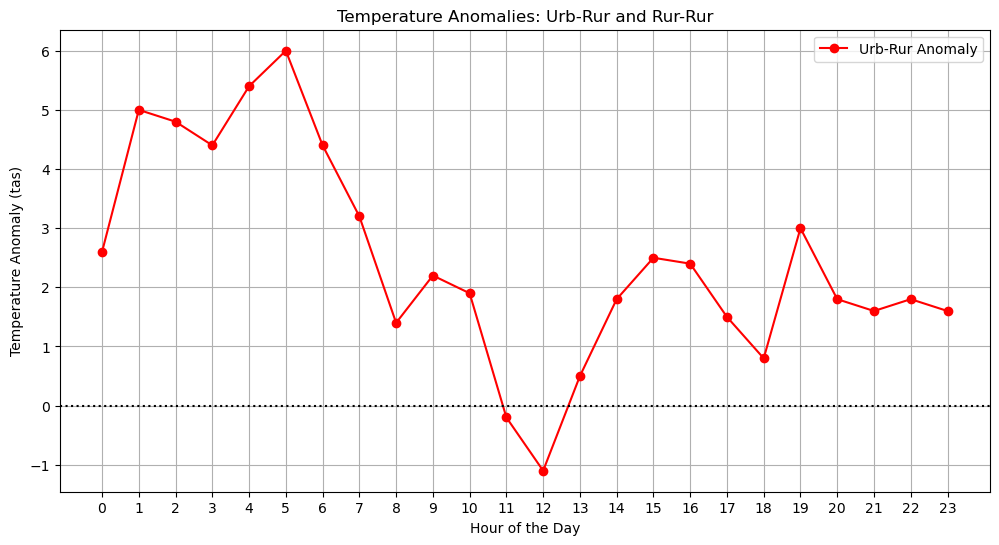

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# Convert the 'DATE' column to datetime, ensuring it's a copy to avoid SettingWithCopyWarning
df_exceedance = df_exceedance.copy()
df_rur = df_rur.copy()
df_urb = df_urb.copy()

# Convertir las columnas 'DATE' a datetime, manejando posibles errores
df_exceedance.loc[:, 'DATE'] = pd.to_datetime(df_exceedance['DATE_only'], errors='coerce')
df_rur.loc[:, 'DATE_only'] = pd.to_datetime(df_rur['DATE'], errors='coerce')
df_urb.loc[:, 'DATE_only'] = pd.to_datetime(df_urb['DATE'], errors='coerce')

df_rur['DATE_only'] = pd.to_datetime(df_rur['DATE_only'], format='%Y-%m-%d', errors='coerce')
df_urb['DATE_only'] = pd.to_datetime(df_urb['DATE_only'], format='%Y-%m-%d', errors='coerce')

# Intentar convertir utilizando un formato explícito (si conoces el formato exacto)
df_rur['DATE'] = pd.to_datetime(df_rur['DATE'], format='%Y-%m-%d %H:%M:%S', errors='coerce')
df_urb['DATE'] = pd.to_datetime(df_urb['DATE'], format='%Y-%m-%d %H:%M:%S', errors='coerce')

# Filtrar filas según la ciudad seleccionada y la fecha correspondiente
if city == 'Cordoba':
    selected_date = pd.to_datetime("2019-12-11")
elif city == 'BuenosAires':
    selected_date = pd.to_datetime("2019-01-28")
else:
    raise ValueError("City not recognized")

df_rur['DATE_only'] = pd.to_datetime(df_rur['DATE_only']).dt.date
df_urb['DATE_only'] = pd.to_datetime(df_urb['DATE_only']).dt.date
df_rur_filtered = df_rur[df_rur['DATE_only'] == selected_date.date()]
df_urb_filtered = df_urb[df_urb['DATE_only'] == selected_date.date()]

# Create the plot
plt.figure(figsize=(12, 6))

# Dictionary to store anomalies
anomalies = {}

# Calculate urb-rur anomaly if both datasets exist
if not df_rur_filtered.empty and not df_urb_filtered.empty:
    # Add 'hour' column before grouping by hour
    df_urb_filtered['hour'] = df_urb_filtered['DATE'].dt.hour
    df_rur_filtered['hour'] = df_rur_filtered['DATE'].dt.hour
    
    urb_rur_anom = df_urb_filtered.groupby('hour')['tas'].mean() - df_rur_filtered.groupby('hour')['tas'].mean()
    plt.plot(urb_rur_anom.index, urb_rur_anom.values, label='Urb-Rur Anomaly', color='red', linestyle='-', marker='o')
    anomalies['urb-rur'] = urb_rur_anom

# Calculate rur-rur anomaly if multiple rural stations exist
station_names_rur = df_rur_filtered['Station Name'].unique()
if len(station_names_rur) > 1:
    mean_rural_tas = df_rur_filtered.groupby('hour')['tas'].mean()

    for station in station_names_rur:
        station_data_rur = df_rur_filtered[df_rur_filtered['Station Name'] == station].copy()
        station_data_rur['hour'] = station_data_rur['DATE'].dt.hour
        rur_rur_anom = station_data_rur.groupby('hour')['tas'].mean() - mean_rural_tas
        plt.plot(rur_rur_anom.index, rur_rur_anom.values, label=f'Rur-Rur Anomaly - {station}', linestyle='--', marker='x')
        anomalies[f'rur-rur_{station}'] = rur_rur_anom


import pandas as pd
import xarray as xr

# Extract the 'urb-rur' anomaly data and hour values
urb_rur_anom = anomalies['urb-rur']
hours = urb_rur_anom.index  # This will be the 'hour' column

# Create the xarray dataset with 'hour' as the coordinate
ds = xr.Dataset(
    {'urban_mean': (['hour'], urb_rur_anom.values)},
    coords={'hour': hours}
)

# Save the dataset to a NetCDF file
ds.to_netcdf(f'results/heatwaves_{city}/tas_{city}-CSAM-4i_OBS_evaluation_r1i1p1f1_acycle_anomaly-ur.nc')


# Finalize the plot
plt.title('Temperature Anomalies: Urb-Rur and Rur-Rur')
plt.xlabel('Hour of the Day')
plt.ylabel('Temperature Anomaly (tas)')
plt.axhline(y=0, color='black', linestyle=':')  # Reference line at 0
plt.xticks(range(0, 24, 1))
plt.grid(True)

# Only add legend if there are valid data
if plt.gca().has_data():
    plt.legend()

# Save the plot to a PDF
output_pdf = f"{base_output_dir}/heatwaves_{city}/tas_OBS_day_cycle_heatwaves-ur.pdf"

# Create the directory if it does not exist
os.makedirs(os.path.dirname(output_pdf), exist_ok=True)

# Save the plot as PDF
plt.savefig(output_pdf, format='pdf')

print(f"Plot saved as: {output_pdf}")

plt.show()


## Comparision betweeen Model and Observation

### Select coincident period between Model and Observations

In [23]:
ds_RCM_selected = ds_RCM.sel(time=ds_RCM.time.dt.year.isin([2018, 2021]))

In [24]:
import numpy as np

def find_nearest_point(ds, lat, lon, lat_var='lat', lon_var='lon'):
    """
    Finds the nearest grid point in an xarray.Dataset to a given latitude and longitude.

    Parameters:
        ds (xarray.Dataset): The dataset containing latitude and longitude variables.
        lat (float): Latitude of the point to find.
        lon (float): Longitude of the point to find.
        lat_var (str): Name of the latitude variable in the dataset. Default is 'lat'.
        lon_var (str): Name of the longitude variable in the dataset. Default is 'lon'.

    Returns:
        xarray.Dataset: A dataset for the nearest latitude and longitude.
    """
    # Extract the latitude and longitude arrays from the dataset
    latitudes = ds[lat_var].values
    longitudes = ds[lon_var].values

    # If longitude range is 0 to 360, convert input longitude to the same range
    if np.max(longitudes) > 180:
        lon = lon % 360

    # Compute the absolute differences
    lat_diff = np.abs(latitudes - lat)
    lon_diff = np.abs(longitudes - lon)

    # Find the indices of the nearest latitude and longitude
    lat_idx = np.argmin(lat_diff)
    lon_idx = np.argmin(lon_diff)

    # Use the indices to select the nearest point in the dataset
    ds_selected = ds.isel(lat=lat_idx, lon=lon_idx)

    # Return the selected dataset
    return ds_selected


In [25]:
selected_row = df[(df['city'] == city) & (df['urban'] == "Urban")].iloc[0]  

lat = selected_row['lat']
lon = selected_row['lon']

ds_selected_urb = find_nearest_point(ds_RCM_selected, lat, lon)

selected_row = df[(df['city'] == city) & (df['urban'] == "Rural")].iloc[0]  

lat = selected_row['lat']
lon = selected_row['lon']

ds_selected_rur = find_nearest_point(ds_RCM_selected, lat, lon)

## Annual

In [26]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def plot_temperatures_and_anomalies_annual(df_urb, df_rur, ds_urb, ds_rur, var, city, output_pdf=None):
    """
    Function to plot temperature data and anomalies for urban and rural stations.
    """
    # Convert 'DATE' to datetime and extract the month for the DataFrames
    df_urb['month'] = pd.to_datetime(df_urb['DATE']).dt.month
    df_rur['month'] = pd.to_datetime(df_rur['DATE']).dt.month

    # Group by month and station for mean (urban and rural) in DataFrames
    df_urb_mean = df_urb.groupby(['month', 'Station Name'])[var].mean().unstack('Station Name')
    df_rur_mean = df_rur.groupby(['month', 'Station Name'])[var].mean().unstack('Station Name')

    # For the xarray datasets (ds_urb and ds_rur), calculate the mean by month
    # Ensure the time dimension is a DateTime object
    ds_urb['time'] = pd.to_datetime(ds_urb['time'].values)
    ds_rur['time'] = pd.to_datetime(ds_rur['time'].values)
    
    ds_urb_mean = ds_urb[var].groupby('time.month').mean('time')
    ds_rur_mean = ds_rur[var].groupby('time.month').mean('time')
    if var == 'pr':
        # Convert from kg/m²/s to kg/m²/day by multiplying by the number of seconds in a day
        ds_urb_mean = ds_urb_mean * (24 * 60 * 60)  # Precipitation in kg/m²/day
        ds_rur_mean = ds_rur_mean * (24 * 60 * 60)  # Precipitation in kg/m²/day
            
    if var == 'hurs':
        df_urb_mean = df_urb_mean * 100
        df_rur_mean = df_rur_mean * 100
  

    # Initialize lists to store anomalies
    anomaly_station = []
    anomaly_model = []

    # Iterate over the months to calculate the anomalies
    for month in range(1, 13):  # Loop over months (1 to 12)
        urban_station_names = df_urb_mean.columns
        rural_station_names = df_rur_mean.columns
        if variable in ['huss', 'pr', 'sfcWind']:
            anomaly_station.append(((df_urb_mean.loc[month, urban_station_names[0]] - df_rur_mean.loc[month, rural_station_names[0]])/
                                   df_urb_mean.loc[month, urban_station_names[0]])*100)
        
            # Calculate the anomaly for the model (Urban - Rural)
            anomaly_model.append(((ds_urb_mean.sel(month=month) - ds_rur_mean.sel(month=month))/ds_urb_mean.sel(month=month))*100)
        else:
            anomaly_station.append(df_urb_mean.loc[month, urban_station_names[0]] - df_rur_mean.loc[month, rural_station_names[0]])
        
            # Calculate the anomaly for the model (Urban - Rural)
            anomaly_model.append(ds_urb_mean.sel(month=month) - ds_rur_mean.sel(month=month))

    # Convert the list of anomalies into DataFrames or arrays
    anomaly_station = pd.DataFrame(anomaly_station, index=range(1, 13))

    ds = xr.Dataset(
        {'urban_mean': (['index'], anomaly_station.iloc[:, 0].values)},
        coords={'index': anomaly_station.index}
    )

    ds.to_netcdf(f'results/{city}-CSAM-4i_OBS/{variable}_{city}-CSAM-4i_OBS_evaluation_r1i1p1f1_acycle-ur.nc')

    anomaly_model = np.array(anomaly_model)

    # Create figure with 2 rows and 1 column (one for the annual cycle, one for anomalies)
    fig, axes = plt.subplots(2, 1, figsize=(18, 10), gridspec_kw={'hspace': 0.4})

    # Plot for the annual cycle (urban and rural temperatures)
    axes[0].plot(df_urb_mean.index, df_urb_mean, label=f'Urban Station')
    axes[0].plot(df_rur_mean.index, df_rur_mean, label=f'Rural Station')
    
    # Plot xarray data for the annual cycle
    axes[0].plot(ds_urb_mean['month'], ds_urb_mean, label='Urban Model', linestyle='--', color='b')
    axes[0].plot(ds_rur_mean['month'], ds_rur_mean, label='Rural Model', linestyle='--', color='g')

    # Set dynamic labels and titles based on 'var' and 'city'
    axes[0].set_xlabel('Month')
    axes[0].set_ylabel(f'{var} (°C)' if var in ['tasmin', 'tasmax'] else f'{var}')
    axes[0].set_title(f'Annual Cycle of {var.capitalize()} in {city}')
    axes[0].set_ylim(-10, 10)  # Set y-axis for the first plot
    axes[0].grid(True)
    axes[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    axes[0].set_xticks(range(1, 13))  # Set x-ticks for each month (1-12)
    axes[0].set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 
                         'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], fontsize=18)  # Set month names


    # Plot for the anomalies (Urban - Rural) temperatures
    axes[1].plot(range(1, 13), anomaly_station, label='Anomaly Station', color='g')
    axes[1].plot(ds_urb_mean['month'], anomaly_model, label='Anomaly Model', linestyle='--', color='b')

    # Set dynamic labels and titles based on 'var' and 'city'
    axes[1].set_xlabel('Month')
    axes[1].set_ylabel(f'{var} Anomaly (Urban - Rural) (°C)' if var in ['tasmin', 'tasmax'] else f'{var} Anomaly (Urban - Rural)')
    axes[1].set_title(f'{var.capitalize()} Anomaly (Urban - Rural) in {city}')
    axes[1].set_ylim(-70, 10)  # Set y-axis for the second plot
    axes[1].grid(True)
    axes[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    axes[1].set_xticks(range(1, 13))  # Set x-ticks for each month (1-12)
    axes[1].set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 
                        'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], fontsize = 18)

    # Adjust layout
    plt.tight_layout()

    # Show the plots
    plt.show()

    return fig


/tmp/ipykernel_55521/1447200175.py:105: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


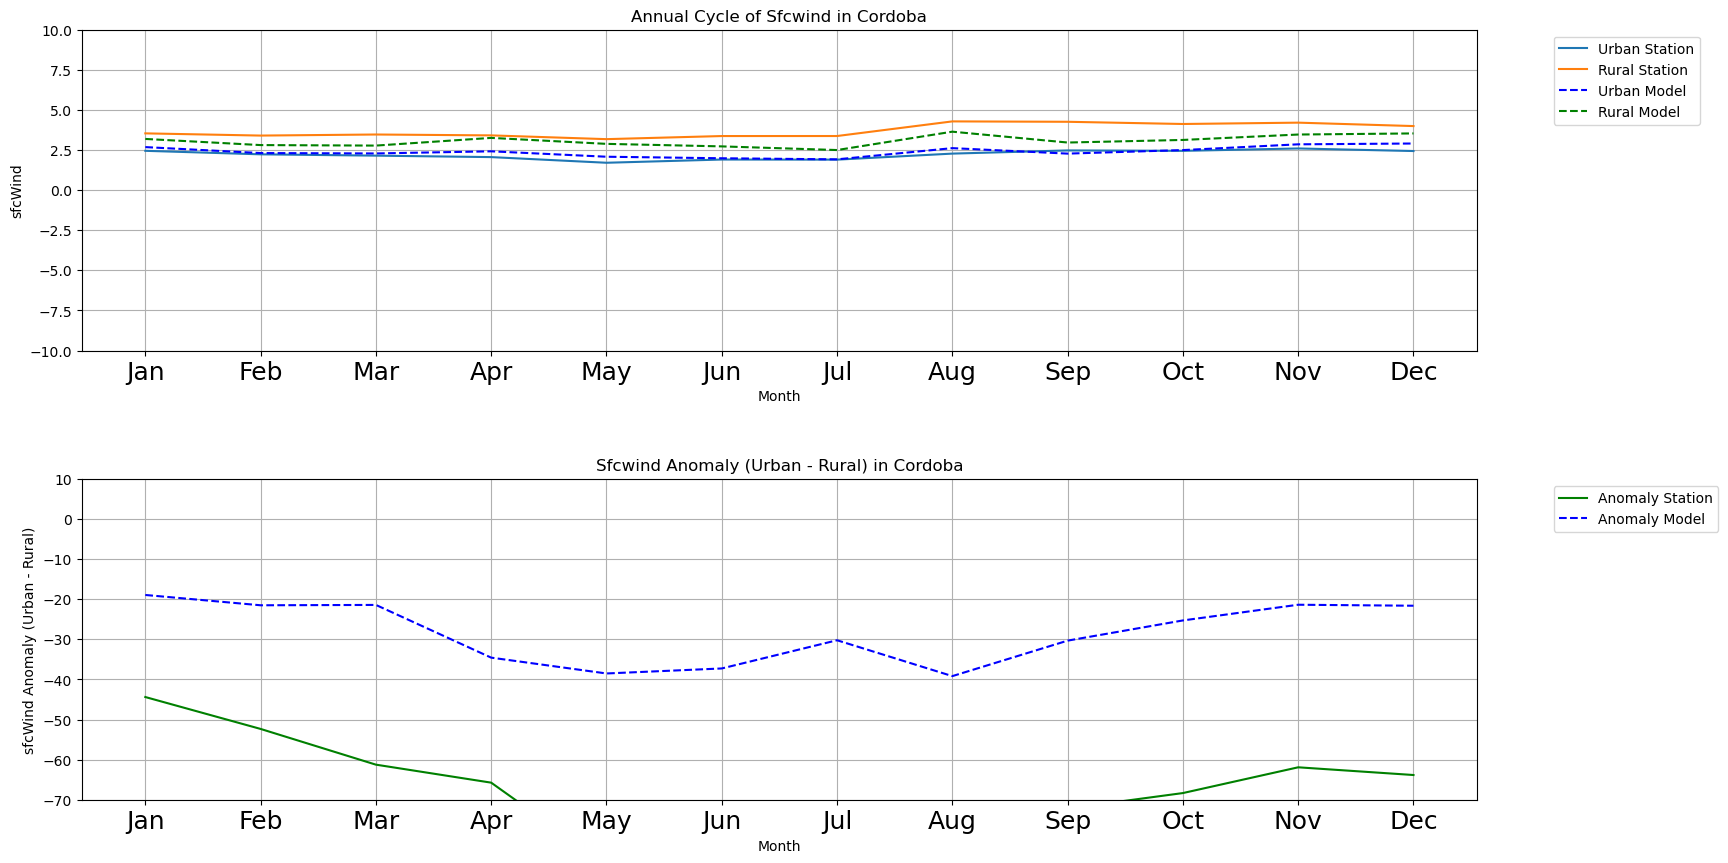

In [27]:
fig=plot_temperatures_and_anomalies_annual(df_urb, df_rur,ds_selected_urb,ds_selected_rur, variable, city)
fig.savefig(f"{output_dir}/{variable}_{base_filename}_OBS_anomaly.pdf", bbox_inches='tight')

## Daily

In [28]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def plot_temperatures_and_anomalies_daily(df_urb, df_rur, ds_urb, ds_rur, var, city):
    """
    Function to plot temperature data and anomalies for urban and rural stations.
    """
    df_urb['DATE'] = pd.to_datetime(df_urb['DATE'])
    df_rur['DATE'] = pd.to_datetime(df_rur['DATE'])


    # Filter data for DJF and JJA
    df_djf_urb = df_urb[df_urb['DATE'].dt.month.isin([12, 1, 2])]
    df_djf_rur = df_rur[df_rur['DATE'].dt.month.isin([12, 1, 2])]
    
    df_jja_urb = df_urb[df_urb['DATE'].dt.month.isin([6, 7, 8])]
    df_jja_rur = df_rur[df_rur['DATE'].dt.month.isin([6, 7, 8])]

    # Extract hour from 'DATE' for grouping
    for df in [df_jja_urb, df_jja_rur, df_djf_urb, df_djf_rur]:
        df['hour'] = df['DATE'].dt.hour

    # Group by hour and station for mean values
    df_urb_jja_mean = df_jja_urb.groupby(['hour', 'Station Name'])[var].mean().unstack('Station Name')
    df_rur_jja_mean = df_jja_rur.groupby(['hour', 'Station Name'])[var].mean().unstack('Station Name')
    df_urb_djf_mean = df_djf_urb.groupby(['hour', 'Station Name'])[var].mean().unstack('Station Name')
    df_rur_djf_mean = df_djf_rur.groupby(['hour', 'Station Name'])[var].mean().unstack('Station Name')

    # Filter xarray datasets for DJF and JJA
    ds_urb_djf = ds_urb.sel(time=ds_urb['time.month'].isin([12, 1, 2]))
    ds_rur_djf = ds_rur.sel(time=ds_rur['time.month'].isin([12, 1, 2]))
    ds_urb_jja = ds_urb.sel(time=ds_urb['time.month'].isin([6, 7, 8]))
    ds_rur_jja = ds_rur.sel(time=ds_rur['time.month'].isin([6, 7, 8]))

    # Calculate hourly means for xarray datasets
    ds_urb_djf_mean = ds_urb_djf[var].groupby(ds_urb_djf['time.hour']).mean(dim='time')
    ds_rur_djf_mean = ds_rur_djf[var].groupby(ds_rur_djf['time.hour']).mean(dim='time')
    ds_urb_jja_mean = ds_urb_jja[var].groupby(ds_urb_jja['time.hour']).mean(dim='time')
    ds_rur_jja_mean = ds_rur_jja[var].groupby(ds_rur_jja['time.hour']).mean(dim='time')
    
    if var == 'pr':
    # Convert from kg/m²/s to kg/m²/day by multiplying by the number of seconds in a day
        ds_urb_djf_mean = ds_urb_djf_mean * (24 * 60 * 60)  # Precipitation in kg/m²/day
        ds_rur_djf_mean = ds_rur_djf_mean * (24 * 60 * 60)  # Precipitation in kg/m²/day
        ds_urb_jja_mean = ds_urb_jja_mean * (24 * 60 * 60)  # Precipitation in kg/m²/day
        ds_rur_jja_mean = ds_rur_jja_mean * (24 * 60 * 60)  # Precipitation in kg/m²/day
    if var == 'hurs':
        df_urb_djf_mean = df_urb_djf_mean *  100 
        df_rur_djf_mean = df_rur_djf_mean * 100 
        df_urb_jja_mean = df_urb_jja_mean * 100
        df_rur_jja_mean = df_rur_jja_mean * 100

    # Calculate anomalies
    if variable in ['huss', 'pr', 'sfcWind']:
        anomaly_station_jja = (df_urb_jja_mean.mean(axis=1) - df_rur_jja_mean.mean(axis=1))*100/df_urb_jja_mean.mean(axis=1)
        anomaly_station_djf = (df_urb_djf_mean.mean(axis=1) - df_rur_djf_mean.mean(axis=1))*100/df_urb_djf_mean.mean(axis=1)
        anomaly_ds_jja = (ds_urb_jja_mean - ds_rur_jja_mean)*100/ds_urb_jja_mean
        anomaly_ds_djf = (ds_urb_djf_mean - ds_rur_djf_mean)*100/ds_urb_djf_mean
    else:
        anomaly_station_jja = df_urb_jja_mean.mean(axis=1) - df_rur_jja_mean.mean(axis=1)
        anomaly_station_djf = df_urb_djf_mean.mean(axis=1) - df_rur_djf_mean.mean(axis=1)
        anomaly_ds_jja = ds_urb_jja_mean - ds_rur_jja_mean
        anomaly_ds_djf = ds_urb_djf_mean - ds_rur_djf_mean
        print(df_urb_djf_mean)

    # Create figure with 2 rows and 2 columns
    fig, axes = plt.subplots(2, 2, figsize=(18, 10), gridspec_kw={'hspace': 0.4})

    # Plot DJF annual cycle
    axes[0, 0].plot(df_urb_djf_mean.index, df_urb_djf_mean.mean(axis=1), label='Urban Station (DJF)', color='b')
    axes[0, 0].plot(df_rur_djf_mean.index, df_rur_djf_mean.mean(axis=1), label='Rural Station (DJF)', color='g')
    axes[0, 0].plot(ds_urb_djf_mean['hour'], ds_urb_djf_mean, label='Urban Model (DJF)', linestyle='--', color='b')
    axes[0, 0].plot(ds_rur_djf_mean['hour'], ds_rur_djf_mean, label='Rural Model (DJF)', linestyle='--', color='g')
    axes[0, 0].set_xlabel('Hour')
    axes[0, 0].set_ylabel(f'{var.capitalize()} (°C)')
    axes[0, 0].set_title(f'{var.capitalize()} Annual Cycle in {city} (Winter)')
    axes[0, 0].legend()
    axes[0, 0].grid(True)

    # Plot JJA annual cycle

    axes[0, 1].plot(df_urb_jja_mean.index, df_urb_jja_mean.mean(axis=1), label='Urban Station (JJA)', color='b')
    axes[0, 1].plot(df_rur_jja_mean.index, df_rur_jja_mean.mean(axis=1), label='Rural Station (JJA)', color='g')
    axes[0, 1].plot(ds_urb_jja_mean['hour'], ds_urb_jja_mean, label='Urban Model (JJA)', linestyle='--', color='b')
    axes[0, 1].plot(ds_rur_jja_mean['hour'], ds_rur_jja_mean, label='Rural Model (JJA)', linestyle='--', color='g')
    axes[0, 1].set_xlabel('Hour')
    axes[0, 1].set_ylabel(f'{var.capitalize()} (°C)')
    axes[0, 1].set_title(f'{var.capitalize()} Annual Cycle in {city} (Summer)')
    axes[0, 1].legend()
    axes[0, 1].grid(True)

    # Plot DJF anomalies
    ds_djf = xr.Dataset(
        {'anomaly_station_djf': (['hour'], anomaly_station_djf.values)},
        coords={'hour': anomaly_station_djf.index.values}
    )


    ds_djf.to_netcdf(f'results/{city}-CSAM-4i_OBS/{variable}_{city}-CSAM-4i_OBS_day_cycle_djf-ur.nc')
    
    axes[1, 0].plot(anomaly_station_djf.index, anomaly_station_djf, label='Station Anomaly (DJF)', color='red')
    axes[1, 0].plot(anomaly_ds_djf['hour'], anomaly_ds_djf, label='Model Anomaly (DJF)', linestyle='--', color='red')
    axes[1, 0].set_xlabel('Hour')
    axes[1, 0].set_ylabel(f'{var.capitalize()} Anomaly ')
    axes[1, 0].set_title(f'{var.capitalize()} Anomaly in {city} (Winter)')
    axes[1, 0].legend()
    axes[1, 0].grid(True)

    # Plot JJA anomalies
    ds_jja = xr.Dataset(
        {'anomaly_station_jja': (['hour'], anomaly_station_jja.values)},
        coords={'hour': anomaly_station_jja.index.values}
    )

    ds_jja.to_netcdf(f'results/{city}-CSAM-4i_OBS/{variable}_{city}-CSAM-4i_OBS_day_cycle_jja-ur.nc')
    
    axes[1, 1].plot(anomaly_station_jja.index, anomaly_station_jja, label='Station Anomaly (JJA)', color='red')
    axes[1, 1].plot(anomaly_ds_jja['hour'], anomaly_ds_jja, label='Model Anomaly (JJA)', linestyle='--', color='red')
    axes[1, 1].set_xlabel('Hour')
    axes[1, 1].set_ylabel(f'{var.capitalize()} Anomaly ')
    axes[1, 1].set_title(f'{var.capitalize()} Anomaly in {city} (Summer)')
    axes[1, 1].legend()
    axes[1, 1].grid(True)

    # Adjust layout and show
    plt.tight_layout()
    plt.show()


/tmp/ipykernel_55521/1067967245.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['hour'] = df['DATE'].dt.hour
/tmp/ipykernel_55521/1067967245.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['hour'] = df['DATE'].dt.hour
/tmp/ipykernel_55521/1067967245.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu

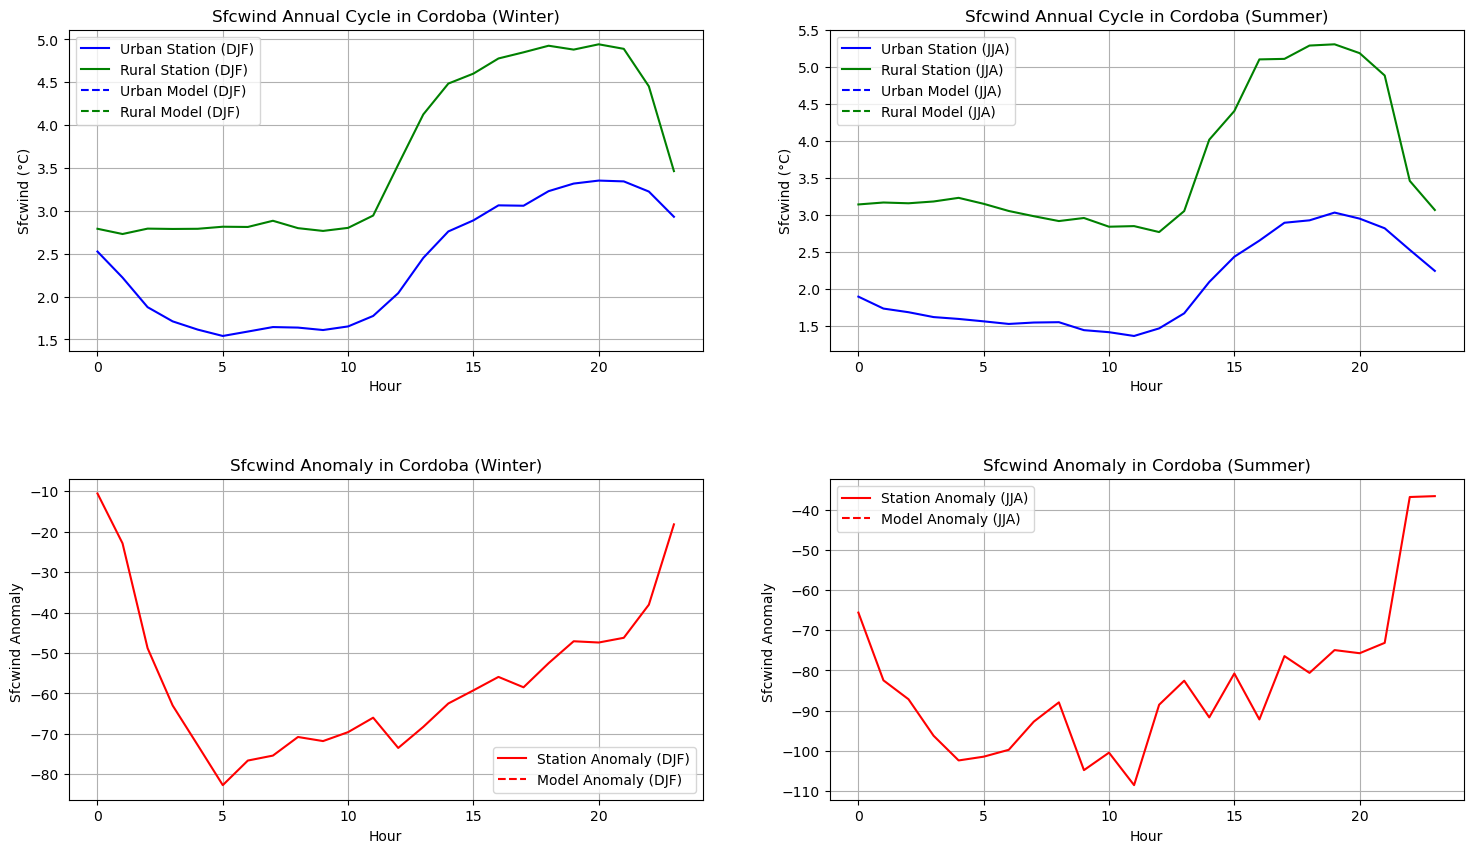

In [29]:
plot_temperatures_and_anomalies_daily(df_urb, df_rur,ds_selected_urb,ds_selected_rur, variable, city)


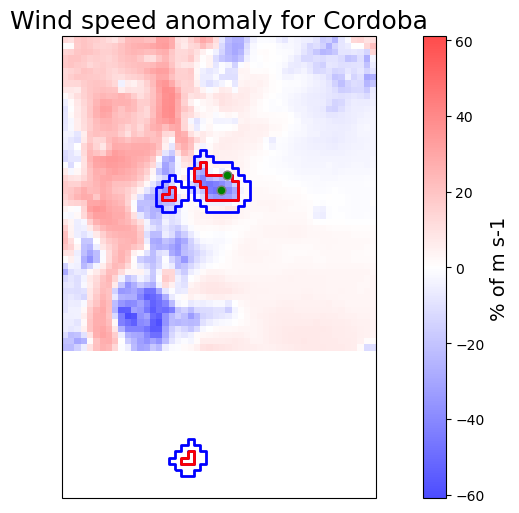

In [30]:
cachefile = f"{output_dir}/{variable}_{base_filename}_map-ur.nc"

fig = plot_climatology(variable, URBAN, ds_RCM,  urmask,  cachefile, 
                       city = city, valid_stations = df, time_series = time_series_obs,
                       alpha_urb_borders = 1,
                       linewidth_urb_borders = 0.6
                      )

cachefile = f"{base_output_dir}/heatwaves_{city}/{variable}_{base_filename}_day_cycle_heatwaves-ur.nc"